# Apply PCI to simulated data 
## Investigate the impact of individual noise contributions

Here we apply PCI to data simulated via the LISA Simulation Suite, following the simulation scripts.

The simulated datasets are 3 days long. PCI is applied to 12 hours of data, with 4 hours of skipped data at the beginning of the simulation.

We need the following simulated datasets:
- full simulation noise dataset (including laser noise and secondary noises), with filename ending in `_measurements_4Hz.h5`
- secondary noises dataset, with filename ending in `_noise_sec_4Hz.h5`

# 0. Installations and data generation

The package dependencies are:

    pip install numpy scipy sympy h5py matplotlib xarray h5py scikit-learn
    pip install lisaconstants
    pip install lisainstrument
    pip install lisagwresponse
    pip install pytdi
    pip install backgrounds

and after installation, the data generation step is performed by running the simulation scripts: 

In [2]:
!pwd

/Users/ecastel2/Documents/virtual-envs/software-install/pcipy/notebooks


In [ ]:
#!python ../simulation/noise_simulation.py /Users/ecastel2/Documents/research/GSFC/pci-inrep/simulations --tdi 2 --baseline --individual

In [ ]:
#!python ../simulation/signal_simulation.py /Users/ecastel2/Documents/research/GSFC/pci-inrep/simulations --tdi 2

In [ ]:
#!python ../simulation/all_sky_signal_simulation.py /Users/ecastel2/Documents/research/GSFC/pci-inrep/simulations --tdi 2

In [5]:
!ls /Users/ecastel2/Documents/research/GSFC/pci-inrep/simulations

2025-03-14_11h05_locking_n1_12_baseline_measurements_4Hz.h5
2025-03-14_11h05_locking_n1_12_baseline_noise_backlink_4Hz.h5
2025-03-14_11h05_locking_n1_12_baseline_noise_clock_4Hz.h5
2025-03-14_11h05_locking_n1_12_baseline_noise_laser_4Hz.h5
2025-03-14_11h05_locking_n1_12_baseline_noise_modulation_4Hz.h5
2025-03-14_11h05_locking_n1_12_baseline_noise_oms_4Hz.h5
2025-03-14_11h05_locking_n1_12_baseline_noise_ranging_4Hz.h5
2025-03-14_11h05_locking_n1_12_baseline_noise_sec_4Hz.h5
2025-03-14_11h05_locking_n1_12_baseline_noise_tdi2_4Hz.h5
2025-03-14_11h05_locking_n1_12_baseline_noise_test-mass_4Hz.h5
2025-03-14_11h05_locking_n1_12_laser_tm_oms_measurements_4Hz.h5
2025-03-14_11h05_locking_n1_12_laser_tm_oms_noise_sec_4Hz.h5
2025-03-14_11h05_locking_n1_12_laser_tm_oms_noise_tdi2_4Hz.h5
2025-03-14_11h34_gw_measurements_4Hz.h5
2025-03-14_11h34_gw_tdi2_4Hz.h5
2025-03-14_11h35_all_sky_gw_measurements_4Hz.h5
2025-03-14_11h35_all_sky_gw_tdi2_4Hz.h5
2025-03-17_14h26_point_gw_measurements_4Hz.h5
2025-03

## 0.1 Settings and imports
Importing the relevant packages for the notebook. Setting up work directories.

In [6]:
import h5py
import os
import numpy as np
from matplotlib import pyplot as plt
from scipy import signal

from datetime import datetime


from pytdi import Data
from pytdi.intervar import ETA_SET

from pcipy import plotting, pci_filter, channel_analysis 


In [7]:
workdir = "/Users/ecastel2/Documents/research/GSFC/pci-inrep/simulations/"
datadir = '/Users/ecastel2/Documents/research/GSFC/simulation-tests/orbits/'

measpath = '_measurements_4Hz.h5'
secondpath = '_noise_sec_4Hz.h5'

orbits = datadir+"keplerian-orbits.h5"

In [8]:
substring = ['locking_n1_12_laser_tm_oms', 'all_sky_gw', 'point_gw']
sims = ["noise", "all_sky", "point_source"]
datasets = dict(zip(sims, substring))

matchfile={}
dtpath={}

for n,d in zip(substring,datasets):
    timestamp=[]
    matchfile[n] = [f for f in os.listdir(workdir) if n in f]
    for m in matchfile[n]:
        # pick latest date
        timestamp.append(datetime.strptime(m[:17], "%Y-%m-%d_%Hh%M_"))
        #print(n, timestamp[n])
        dtpath[d] = max(timestamp).strftime("%Y-%m-%d_%Hh%M_")
dtpath

{'noise': '2025-03-19_13h05_',
 'all_sky': '2025-03-19_13h32_',
 'point_source': '2025-03-19_13h32_'}

In [9]:
skip_hours=4
pci_hours=12

## 1. Build data vector of the six LISA single-link channels

To build the data vector of the six LISA single-link channels $\vec{y} = \left[y_{ij}\right]$, with $i,j=1,2,3$ and $i\neq j$ we resort to the intermediary TDI variables $\eta$, implemented within `pytdi` as `ETA_SET`.


We build the single link $\vec{y}$ data vector for the full noise simulation and for the secondary noises, ending up with two single link vectors:
- full simulation single link vector $\vec{y}^{\text{full}}$
- secondary noises single link vector $\vec{y}^{\text{sec}}$

In [10]:
def build_data_vector(data_noise, skip=300, dtype=np.float64):
    central_freq = 281600000000000.0
    # Conventions 1, 2, 3, 1p, 2p, 3p
    delays_order = ['23', '31', '12', '32', '13', '21']
    mosas_order = ['12', '23', '31', '13', '21', '32']
    # Form intermediary variables for full data
    ETA_data_set = {key: ETA_SET[key].build(**data_noise.args) for key in ETA_SET.keys()}
    eta_noise_set = {key: ETA_data_set[key](data_noise.measurements) for key in ETA_data_set.keys()}
    # Form the measurement vector for moving arms containing all noises
    y = np.array([eta_noise_set[f'eta_{mosa}'] / central_freq for mosa in mosas_order], dtype=dtype).T
    y_full = y[skip:, :]
    del y

    return y_full

In [59]:
# Get noise simulation measurements
simpath = workdir + dtpath['noise'] + datasets['noise'] + measpath
print(simpath)
# load hdf5 file to read data attrs
sim = h5py.File(simpath, 'r')
# read attrs
central_freq = sim.attrs['central_freq']
dt = sim.attrs['dt']
n_data = sim.attrs['size']
# load data
data_noise = Data.from_instrument(simpath)
# set sampling frequency
fs = data_noise.fs

# We skip the earliest part of the sim which is not representative
skip = int(skip_hours * 3600 * fs)  
# build data vector of full simulation data
y_full = build_data_vector(data_noise, skip=skip, dtype=np.float64)
# create time vector for plotting
times = np.arange(len(y_full))*dt

You are using a measurement file in a version that might not be fully supported


/Users/ecastel2/Documents/research/GSFC/pci-inrep/simulations/2025-03-19_13h05_locking_n1_12_laser_tm_oms_measurements_4Hz.h5


In [60]:
# Get secondary noises
secpath = workdir + dtpath['noise']+ datasets['noise'] + secondpath
print(secpath)
# load data
data_sec = Data.from_instrument(secpath)
# build data vector of secondary noises   
y_sec = build_data_vector(data_sec, skip=skip, dtype=np.float64)

You are using a measurement file in a version that might not be fully supported


/Users/ecastel2/Documents/research/GSFC/pci-inrep/simulations/2025-03-19_13h05_locking_n1_12_laser_tm_oms_noise_sec_4Hz.h5


### 1.2 Data quicklook

Check the stencil size and take a look at the generated $y$s.

TDI2 fractional delay Lagrange interpolating polynomials are of order `31=1+15*2`

Overall TDI delays are up to 8x single link delay = `8.34 s * 4 Hz * 8` = about 267 sample. Add 15 on each end: `267 + 2*15 = 297` 

TDI2 overall stencil is then about 297 samples

aPCI overall stencil width is `1 + nhalf*2`

In [62]:
nhalf = 45
ns = int(pci_hours * 3600 * fs) 
window = np.ones(ns)

Plot 4000 data samples:

zsh:1: command not found: free


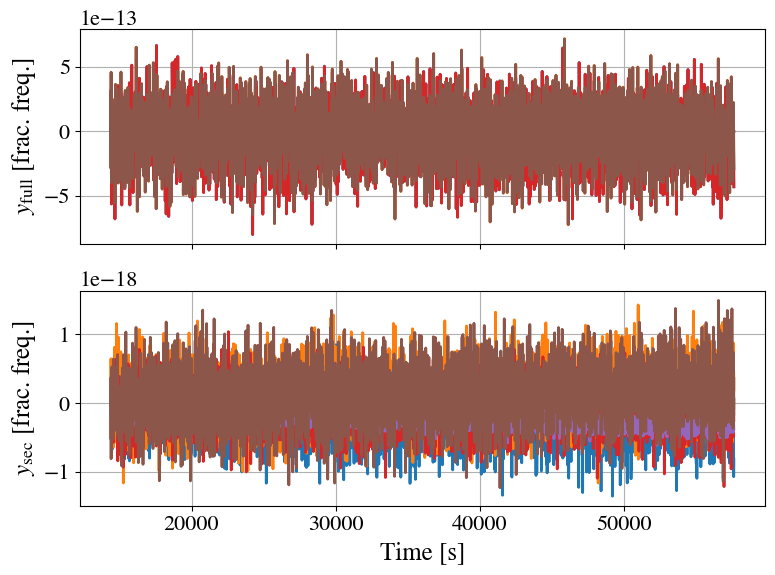

In [58]:
# Time series quicklook
maxshow=4000
ev=ns//maxshow+1
fig, axes = plt.subplots(2, 1, figsize=(8, 6), sharex = True)
for ich in range(len(y_full.T)):
    axes[0].plot(times[skip:skip+ns:ev], y_full[skip:skip+ns:ev, ich])
for ich in range(len(y_sec.T)):
    axes[1].plot(times[skip:skip+ns:ev], y_sec[skip:skip+ns:ev, ich])
axes[1].set_xlabel('Time [s]')
axes[0].set_ylabel(r"$y_\text{full}$ [frac. freq.]")
axes[1].set_ylabel(r"$y_\text{sec}$ [frac. freq.]")
axes[0].grid(), axes[1].grid()
!free

## 2. Apply PCI to the data

We now resort to {class}`PCIFilter` to evaluate PCI from $\vec{y}$.

An instance of {class}`PCIFilter` has two required inputs:
- `ydata`: matrix with the single link LISA temporal phase data streams $\vec{y}$ of length `ns`.
- `fs`: sampling rate of the data streams (Hz).

The optional parameters are
- `nhalf`: filter stencil halfwidth in samples. The default is 45.
- `order`: order of PCI. The default is 1.
- `maxcompts`: PCA results will be truncated to this length after initial processing. The default is 10.
- `Tscale`: if dt is None, then dt defaults to Tscale/ns

The input channels $\vec{y}$ are stretches of data, usually of length `ns+2*nhalf`, but sometimes varying. The variations are:
  - `:` (full length of matrix)
  - `0:ns_fixed`
  - `0:ns+2*nhalf`
  - `skip:skip+ns+2*nhalf`
  
In every case the window is trivial `np.ones([data lenght])`

The`PCIFilter` class applies the following methods in order:

1. `pcipy.PCIFilter.build_data_matrix`
Pre-process $\vec{y}$ data `ydata` to build a matrix of shifted time-series. 

Output is a matrix $\vec{X}$ of size with size `ns` x `(2*nhalf+1)*nc` [what's `nc`?], where 

2. `pcipy.PCIFilter.apply_pca`

3. `pcipy.PCIFilter.set_stencil`

### 2.1 Evaluate PCI on full data
#### 2.1.1 Sort components by variance

In [15]:
# import importlib
# importlib.reload(pci_filter)

Tscale=10
pca_list = [pci_filter.PCIFilter(y_full[:ns+2*nhalf, :].T,
                                 fs=fs, 
                                 nhalf=nhalf, 
                                 order=q, 
                                 maxcompts=10, 
                                 Tscale=Tscale,
                                 sort_by_rms=False)            
            for q in range(3)]

#c5demand8 mem peak 77%   ???
#              total        used        free      shared  buff/cache   available
#Mem:       15911316     1540616    13584348        1276      786352    14088684

!free


(172800, 546)
variance check rms: 5.0515253737010725e-09
shapes of chans, cov, components: (10, 172800) (10, 10) (10, 546)
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
channel covariance diagonality test on 10 components: 7.09944140781225e-10
component diagonality test on 10 components: 5.945170635635361e-16
(172800, 1092)
variance check rms: 1.651817262867249e-08
shapes of chans, cov, components: (10, 172800) (10, 10) (10, 1092)
[1.00000001 1.         1.         1.         1.         1.
 1.         1.00000001 1.         1.        ]
channel covariance diagonality test on 10 components: 3.0166606737449602e-09
component diagonality test on 10 components: 1.0494579901333217e-15
(172800, 1638)
variance check rms: 5.013402247437869e-08
shapes of chans, cov, components: (10, 172800) (10, 10) (10, 1638)
[1.00000001 1.00000001 0.99999999 1.00000001 1.00000001 0.99999998
 1.         0.99999998 1.         1.        ]
channel covariance diagonality test on 10 components: 8.489207691789103e-09
component diagon

#### 2.1.2 Sort components by RMS

In [16]:
pca_list_rs = [pci_filter.PCIFilter(y_full[:ns+2*nhalf, :].T,
                                    fs=fs, 
                                    nhalf=nhalf, 
                                    order=q, 
                                    maxcompts=10, 
                                    Tscale=Tscale,
                                    sort_by_rms=True)            
            for q in range(3)]

#c5demand8 mem peak 77%   ???
#              total        used        free      shared  buff/cache   available
#Mem:       15911316     1540616    13584348        1276      786352    14088684

!free


(172800, 546)
variance check rms: 5.0515253737010725e-09
shapes of chans, cov, components: (10, 172800) (10, 10) (10, 546)
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
channel covariance diagonality test on 10 components: 7.09944140781225e-10
component diagonality test on 10 components: 5.945170635635361e-16
(172800, 1092)
variance check rms: 1.651817262867249e-08
shapes of chans, cov, components: (10, 172800) (10, 10) (10, 1092)
[1.         1.         1.         1.         1.         1.00000001
 1.         1.00000001 1.         1.        ]
channel covariance diagonality test on 10 components: 3.197151569646011e-09
component diagonality test on 10 components: 9.884284920337296e-16
(172800, 1638)
variance check rms: 5.013402247437868e-08
shapes of chans, cov, components: (10, 172800) (10, 10) (10, 1638)
[1.00000001 1.         1.         1.00000001 1.00000001 0.99999999
 1.         1.00000001 0.99999998 1.        ]
channel covariance diagonality test on 10 components: 8.683845658065606e-09
component 

#### 2.1.3 Detrend the components to get zero mean data

In [17]:
pca_list_zm = [pci_filter.PCIFilter(y_full[:ns+2*nhalf, :].T,
                                    fs=fs, 
                                    nhalf=nhalf, 
                                    order=q, 
                                    maxcompts=10, 
                                    Tscale=Tscale,
                                    zero_mean=True)            
            for q in range(3)]

ys (6, 172890)
means [-2.08637318e-14 -1.03981458e-14 -5.26756117e-20 -2.08625282e-14
 -1.70377262e-19 -1.03992173e-14]
new means [ 2.61648677e-30  3.36405442e-30 -2.10316139e-36  7.73732516e-30
  3.61458585e-35 -2.24270294e-30]
(172800, 546)
variance check rms: 6.673647208102183e-09
shapes of chans, cov, components: (10, 172800) (10, 10) (10, 546)
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
channel covariance diagonality test on 10 components: 4.3835078252189574e-10
component diagonality test on 10 components: 7.321027116143997e-16
ys (6, 172890)
means [-2.08637318e-14 -1.03981458e-14 -5.26756117e-20 -2.08625282e-14
 -1.70377262e-19 -1.03992173e-14]
new means [ 2.61648677e-30  3.36405442e-30 -2.10316139e-36  7.73732516e-30
  3.61458585e-35 -2.24270294e-30]
(172800, 1092)
variance check rms: 1.452791516592605e-08
shapes of chans, cov, components: (10, 172800) (10, 10) (10, 1092)
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
channel covariance diagonality test on 10 components: 3.0752973425300457e-09
component d

### 2.2 Plot PCI decomposition

Compare data sorted by variance with data sorted by RMS.

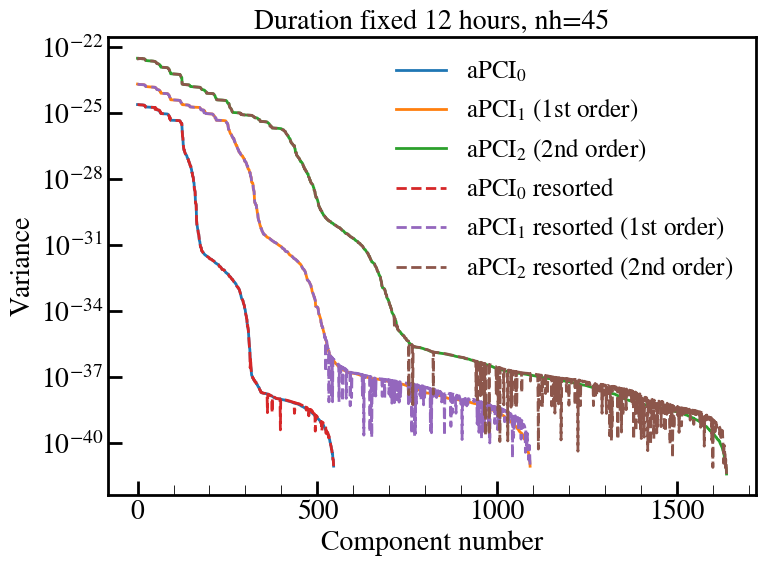

zsh:1: command not found: free


In [65]:
plotting.plotconfig(lbsize=20, lgsize=16, fsize=18, 
                    ticklabelsize=20, style='publication',
                    fontfamily = 'STIXGeneral')

fig1, ax1 = plt.subplots(nrows=1)

ax1.plot(pca_list[0].explained_variance, 
            #linestyle='dashed',
            label=r'aPCI$_0$',
            linewidth=2,
            rasterized=False)

ax1.plot(pca_list[1].explained_variance, 
            #linestyle='dashed',
            label=r'aPCI$_1$ (1st order)',
            linewidth=2,
            rasterized=False)

ax1.plot(pca_list[2].explained_variance,
            #linestyle='dashed',
            label=r'aPCI$_2$ (2nd order)',
            linewidth=2,
            rasterized=False)

if True:
    ax1.plot(pca_list_rs[0].explained_variance, 
                linestyle='dashed',
                label=r'aPCI$_0$ resorted',
                linewidth=2,
                rasterized=False)

    ax1.plot(pca_list_rs[1].explained_variance, 
                linestyle='dashed',
                label=r'aPCI$_1$ resorted (1st order)',
                linewidth=2,
                rasterized=False)

    ax1.plot(pca_list_rs[2].explained_variance,
                linestyle='dashed',
                label=r'aPCI$_2$ resorted (2nd order)',
                linewidth=2,
                rasterized=False)

if False:
    ax1.plot(pca_list_zm[0].explained_variance, 
                linestyle='dotted',
                label=r'aPCI$_0$ zm',
                linewidth=2,
                rasterized=False)

    ax1.plot(pca_list_zm[1].explained_variance, 
                linestyle='dotted',
                label=r'aPCI$_1$ zm (1st order)',
                linewidth=2,
                rasterized=False)

    ax1.plot(pca_list_zm[2].explained_variance,
                linestyle='dotted',
                label=r'aPCI$_2$ zm (2nd order)',
                linewidth=2,
                rasterized=False)

ax1.set_xscale('linear')
ax1.set_yscale('log')
ax1.set_xlabel(r"Component number", fontsize=20)
ax1.set_ylabel("Variance", fontsize=20)
# ax1.set_ylim([1e-42, 1e-25])
ax1.minorticks_on()
plt.legend(loc='upper right', frameon=False)
plt.title("Duration fixed "+str(int(ns/fs/3600))+ " hours, nh=" + str(nhalf))
plt.show()
!free
#for i in range(3):
#    print(pca_list[i].explained_variance-pca_list_zm[i].explained_variance)

## 3. Run channel analysis on the PCI output

The channel analysis we run here does the following:
- Compare stationarity of the data, for each applied PCI order

i= 0
mean: 1.4478532661713276e-22
variance:  9.162228212267255e-42
mean: 3.9352952890659175e-22
variance:  1.7899904970262497e-41
mean: -1.0967152089387179e-21
variance:  1.8416400894228458e-41
mean: -4.873849057040698e-22
variance:  3.517771401106114e-41
mean: -1.614025338640644e-21
variance:  3.5315800164283566e-41
mean: 2.270783659655777e-21
variance:  5.007250445171083e-41
i= 1
mean: -2.466147851765994e-21
variance:  9.092308358047054e-42
mean: -2.380451675593206e-21
variance:  3.469422536934631e-41
mean: -2.079985575390934e-21
variance:  8.058755732760693e-41
mean: -8.330733928916636e-21
variance:  1.7187420394736156e-41
mean: -8.72100037842152e-21
variance:  1.8176382952396173e-41
mean: -7.088544674134626e-21
variance:  7.109931654304589e-41
i= 2
mean: 2.6177349791270196e-22
variance:  4.036997578406827e-42
mean: 1.265275624210616e-21
variance:  1.548638647541859e-41
mean: -1.951541311460879e-21
variance:  1.8152511227444625e-41
mean: 3.985139375137535e-21
variance:  7.7346928646

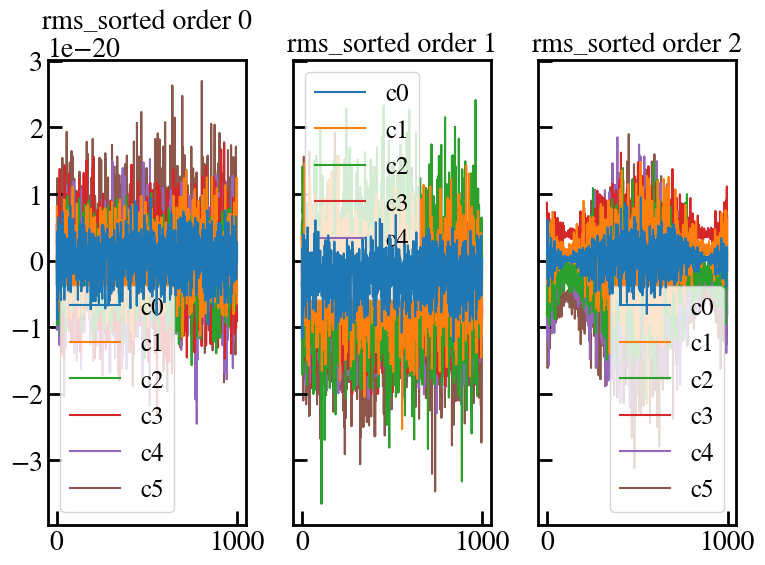

In [71]:
order=2
ev=100

# select which order of PCI filter you want to look at
filters=[pca_list_rs[o] for o in range(order+1)]
# select titles for plot
titles = ['rms_sorted order '+str(o) for o in range(order+1)]
# CONTROLLA COSA FA APPLY FOR CHANNELS
sets=[np.array(xf.apply_for_channels(y_full[:ns+2*nhalf, :].T, 
                                     n_channels=6,
                                     zero_mean=False,
                                     detrend=False)) 
      for xf in filters]
# run channel analysis on selected channels and filter orders
channel_analysis.stationarity_plots(sets,
                                    title=titles)

i= 0
plotting 6 of 6 channels
subtracting bin means!
shape of input,trimmed,binned (6, 172800) (6, 172000) (6, 172, 1000)
172 batches of size 1000
i= 1
plotting 6 of 6 channels
subtracting bin means!
shape of input,trimmed,binned (6, 172800) (6, 172000) (6, 172, 1000)
172 batches of size 1000
i= 2
plotting 6 of 6 channels
subtracting bin means!
shape of input,trimmed,binned (6, 172800) (6, 172000) (6, 172, 1000)
172 batches of size 1000


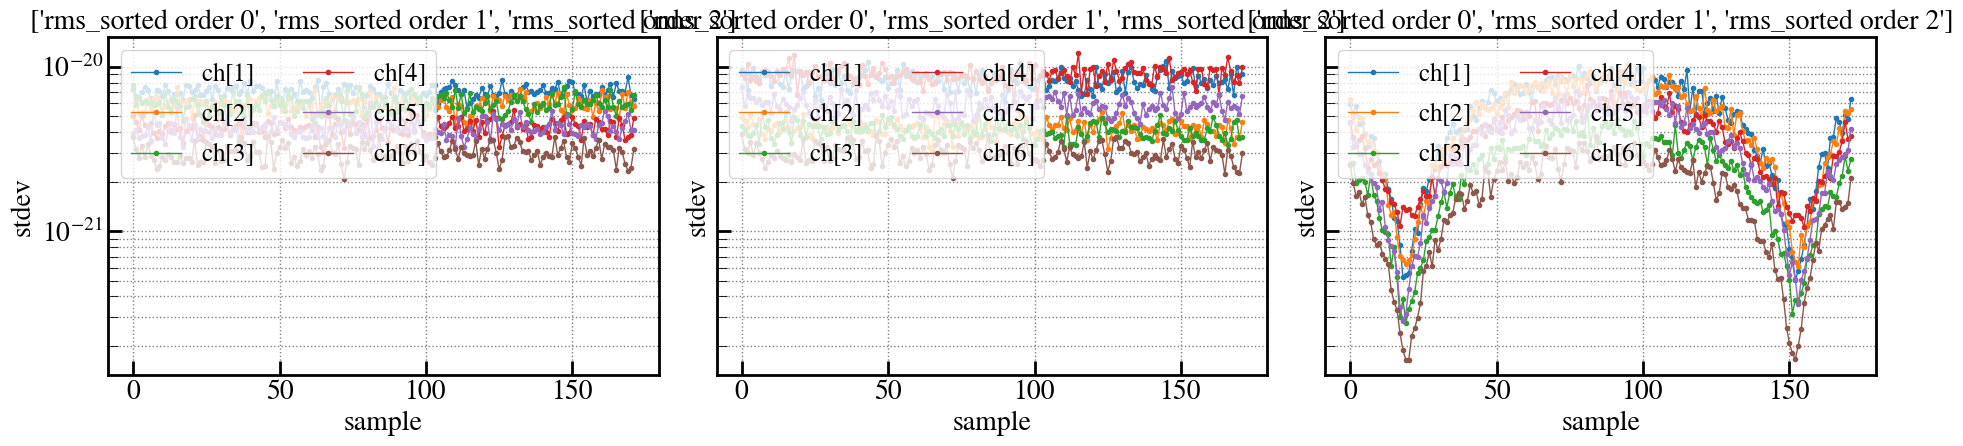

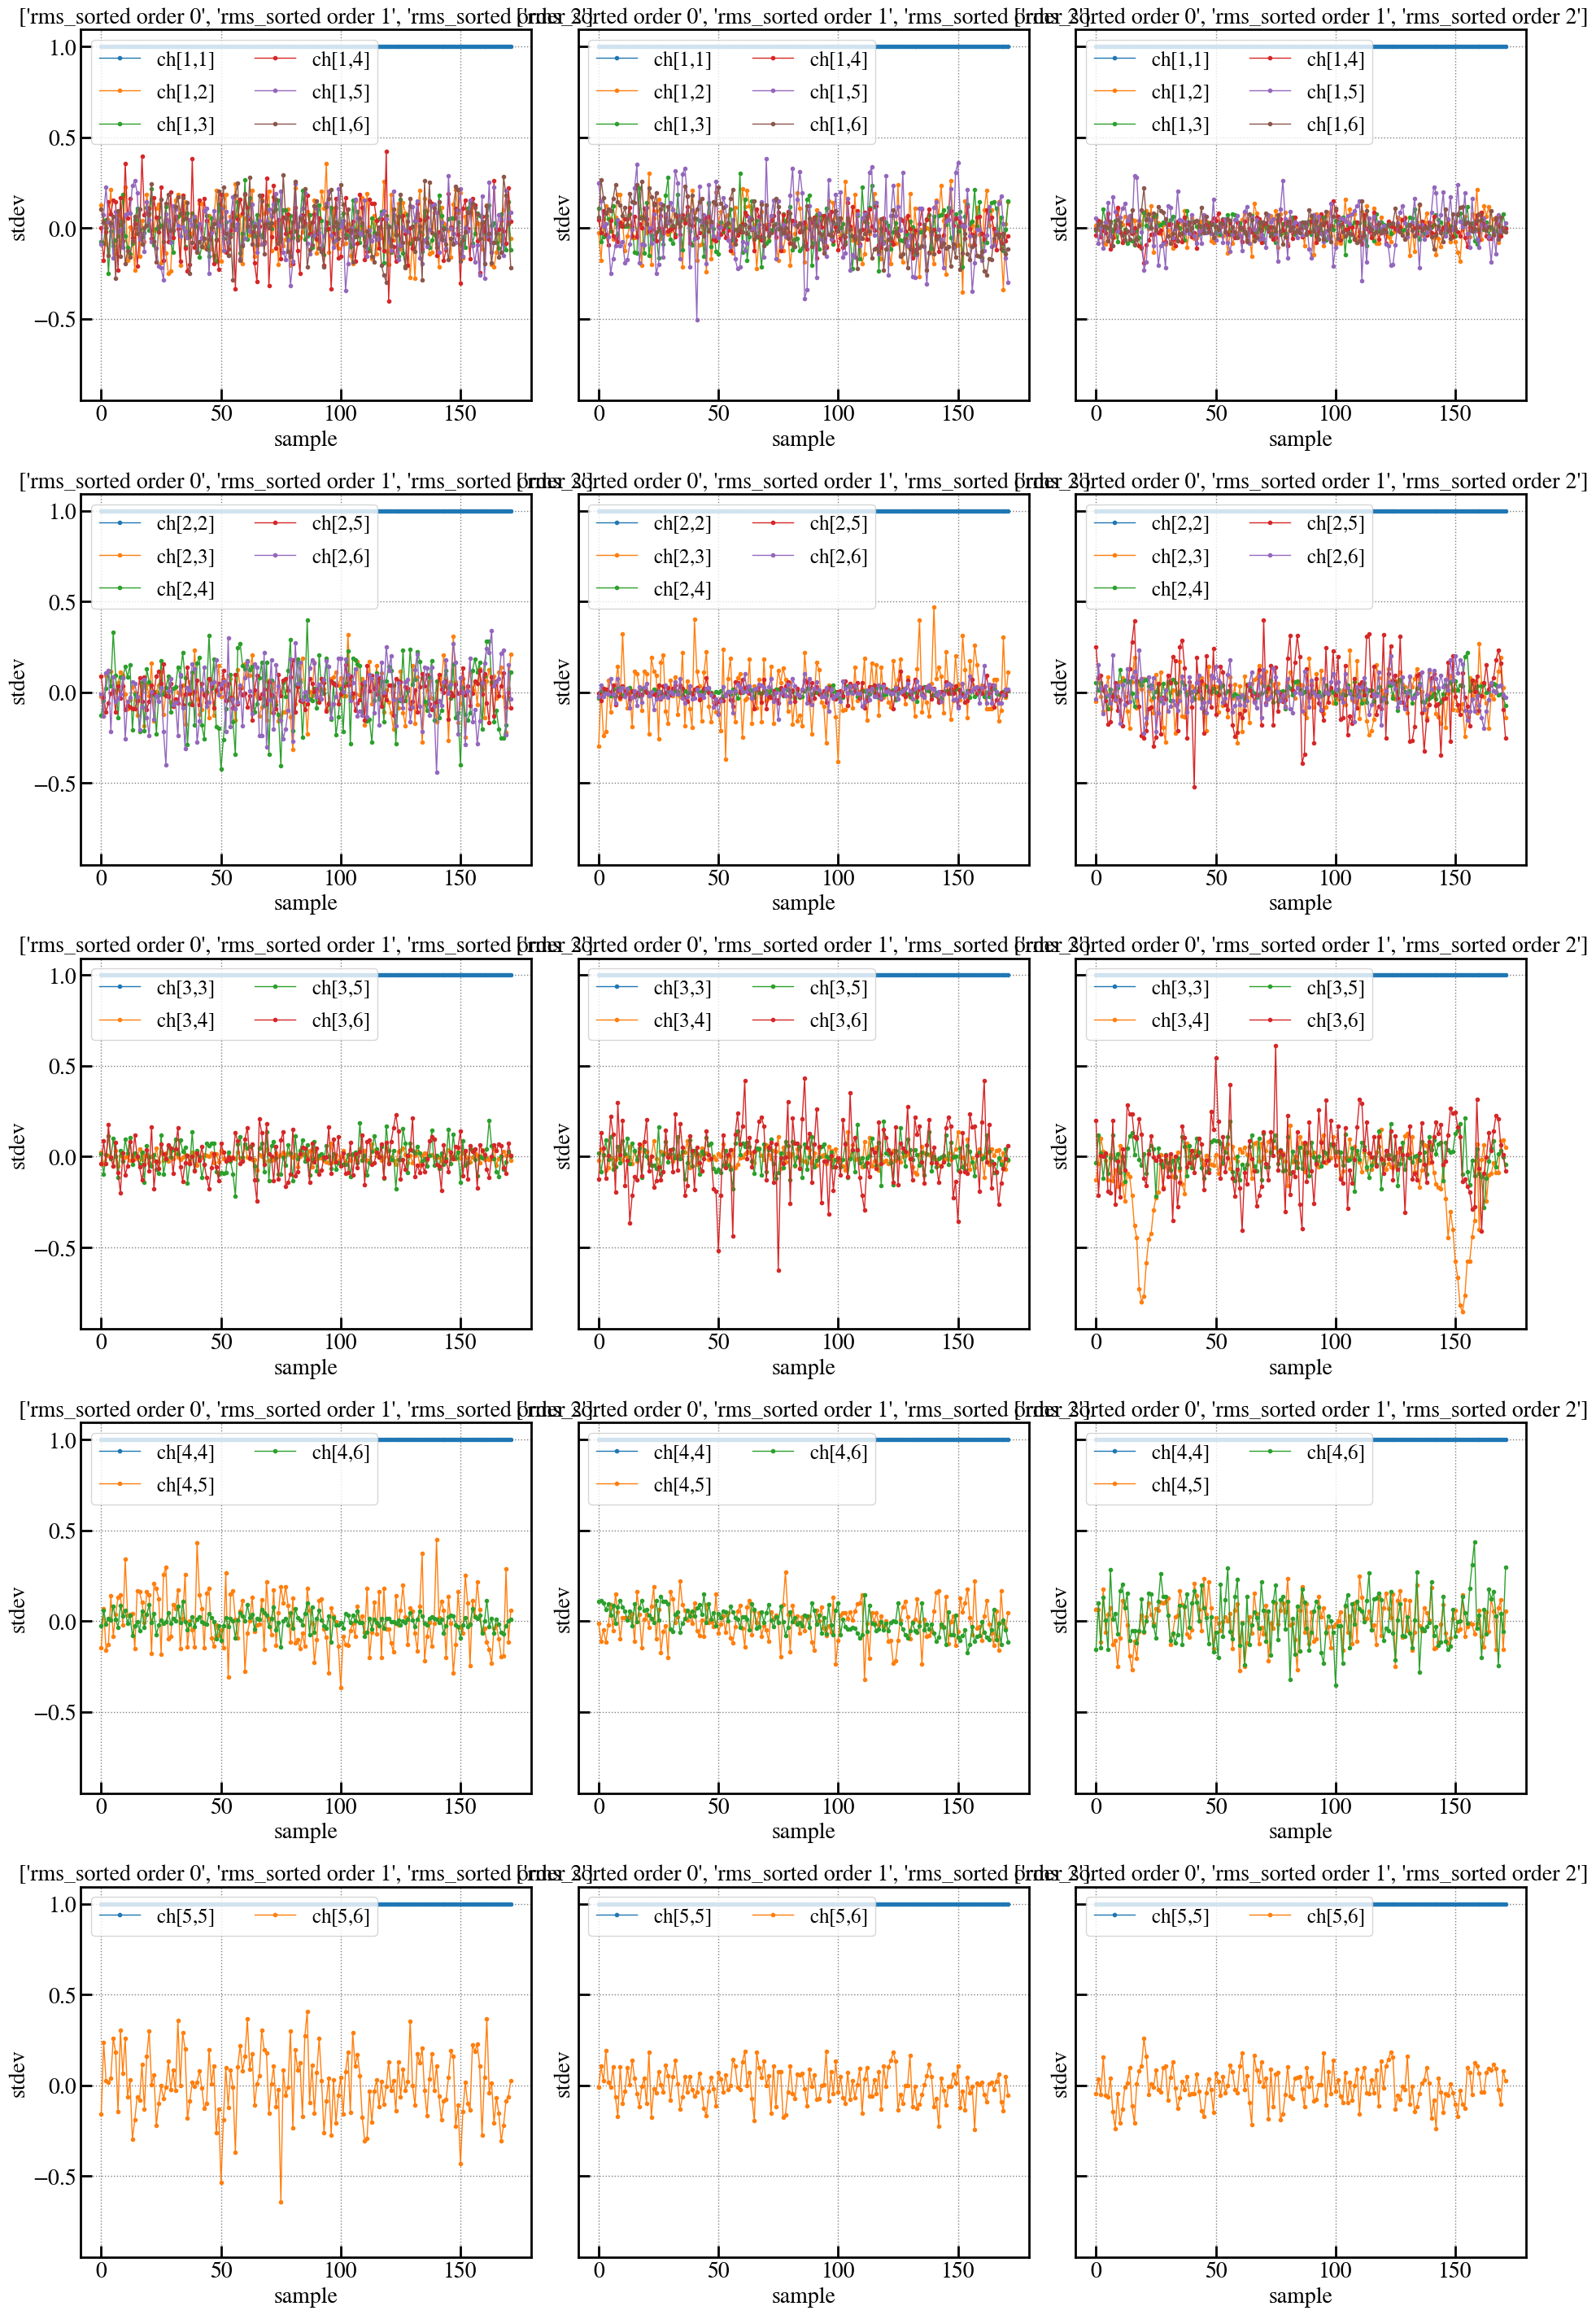

In [73]:
order=2
ev=100

# select which order of PCI filter you want to look at
filters=[pca_list_rs[o] for o in range(order+1)]
# select titles for plot
titles = ['rms_sorted order '+str(o) for o in range(order+1)]

# select data channels (?)
sets=[np.array(xf.apply_for_channels(y_full[:ns+2*nhalf, :].T,
                                     n_channels=6,
                                     zero_mean=False,detrend=False)) 
      for xf in filters]
# FIX TITLES IN THIS PLOT FUNCTION
channel_analysis.temporal_variance_corr_plots(sets,
                                              nchan=6,
                                              title=titles)

### 3.1 Frequency Domain analysis

In [75]:
def compute_welch_matrix(ydata, **kwargs):
    """
    Compute the welch estimated PSDs and CSDs of a multivariate time series.

    Parameters
    ----------
    ydata : ndarray
        array of time series, size n_samples x n_channels
    """

    fy, _ = signal.welch(ydata[:, 0], **kwargs)
    welch_mat = np.zeros((fy.shape[0], ydata.shape[1], ydata.shape[1]), dtype=np.complex128)

    for i in range(ydata.shape[1]):
        _, welch_mat[:, i, i] = signal.welch(ydata[:, i], **kwargs)

        for j in range(i+1, ydata.shape[1]):
            _, welch_mat[:, i, j] = signal.csd(ydata[:, i], ydata[:, j], **kwargs)
            welch_mat[:, j, i] = np.conjugate(welch_mat[:, i, j])

    return fy, welch_mat


Apply Welch to matrix of time-shifted $y$s:

In [76]:
# Welch settings
nperseg = 2**16 # didn't work with some, too short data segment (6hr)?
nperseg = 2**14

kwargs = {"fs": fs,
          "window": 'blackman',
          "nperseg": nperseg,
          "detrend": 'constant',
          "return_onesided": True,
          "scaling": 'density'}

# apply Welch
freqs, y_welch_mat = compute_welch_matrix(y_full, **kwargs)
freqs, y_sec_welch_mat = compute_welch_matrix(y_sec, **kwargs)

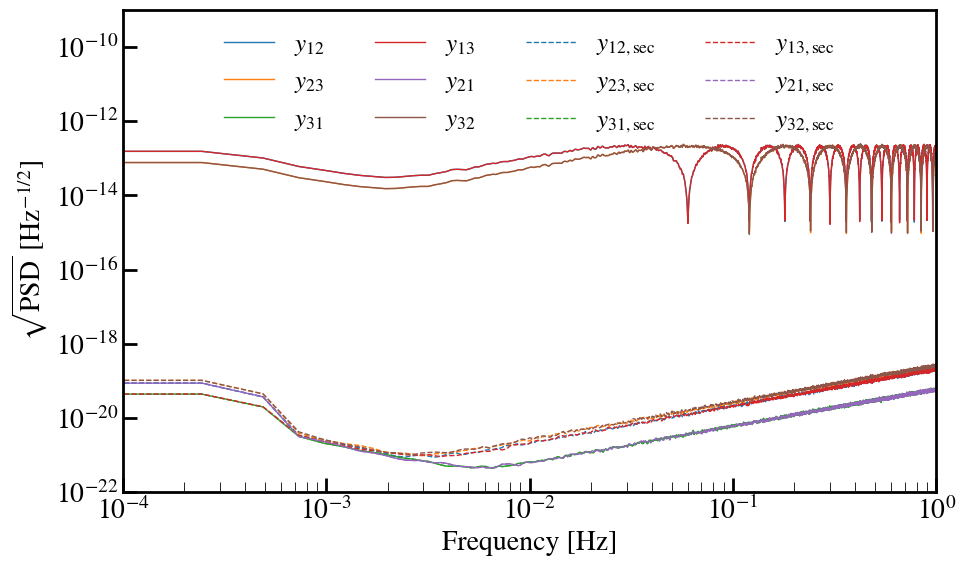

In [80]:
# define ordering of the MOSAs in the constellation
mosas_order = ['12', '23', '31', '13', '21', '32']

# Vizualize the single-link measurements in frequency domain
plotting.plotconfig(lbsize=20, lgsize=16, fsize=18, 
                    ticklabelsize=20, style='publication',
                    fontfamily = 'STIXGeneral')

# plot
fig, axes = plt.subplots(1, 1, figsize=(10, 6))
# For APCI
for i in range(6):
    axes.loglog(freqs, np.sqrt(y_welch_mat[:, i, i].real), 
                linewidth=1, 
                label=r'$y_{\mathrm{'+mosas_order[i]+'}}$',
                rasterized=True)
plt.gca().set_prop_cycle(None)
for i in range(6):
    axes.loglog(freqs, np.sqrt(y_sec_welch_mat[:, i, i].real), 
                linewidth=1,ls='--', 
                label=r'$y_{\mathrm{'+mosas_order[i]+',sec}}$',
                rasterized=True)
axes.legend(loc='upper center', ncol=4, frameon=False)
# axes.grid(linewidth=1, which='both', 
#           color='gray', 
#           linestyle='dotted')
axes.set_xlabel("Frequency [Hz]")
axes.set_ylabel(r"$\mathrm{\sqrt{PSD}}$ [$\mathrm{Hz}^{-1/2}$]")
axes.set_xlim([1e-4, 1])
axes.set_ylim([1e-22, 1e-9])
# axes.set_title("Single-link periodograms")
fig.savefig("single-link-periodogram.pdf", format="pdf", dpi=300)
plt.show()

## 4. Reconstruct single-link channels

Computing single link
single link shape (6, 172800)
single link shape (6, 172800)
Computed single link
i= 0
mean: -9.499257296855916e-25
variance:  1.194136340195682e-46
mean: 5.443251356739126e-22
variance:  2.8806964775139374e-43
mean: -4.010878822041997e-24
variance:  1.4801442899862571e-46
mean: 1.7502277529472813e-22
variance:  4.323725633859232e-43
mean: 1.503829664902697e-24
variance:  1.2890104287579639e-46
mean: 4.010881178984173e-24
variance:  1.4801433751285683e-46
i= 1
mean: 6.384078650919472e-24
variance:  4.450136490795388e-47
mean: 1.537363970383173e-22
variance:  1.6745506428703258e-43
mean: 1.8410762018082515e-23
variance:  1.121868218853372e-46
mean: 4.3487723881855165e-22
variance:  1.5372487823038546e-43
mean: -6.651758936837363e-24
variance:  4.2529988706495664e-47
mean: -1.841076040619318e-23
variance:  1.1218681424428794e-46
i= 2
mean: 7.52600197907561e-20
variance:  1.483510887518964e-37
mean: -1.7037711284032992e-19
variance:  1.1610199233805127e-38
mean: -5.23

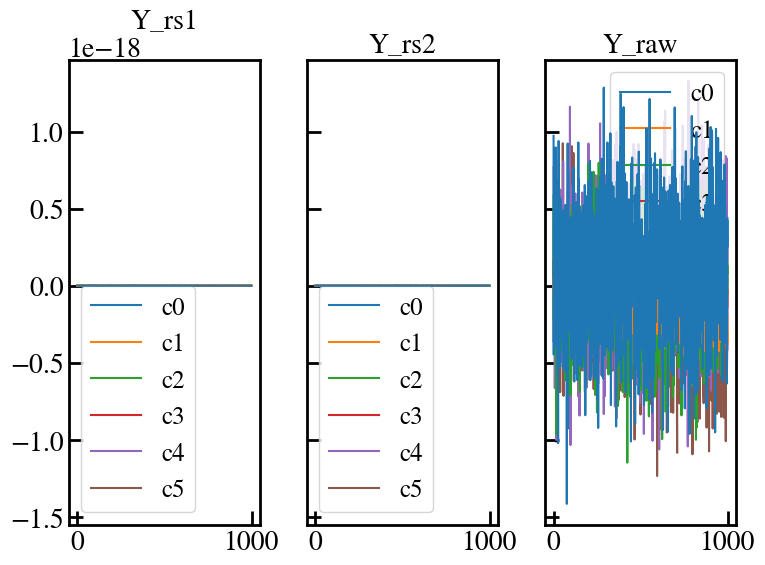

In [81]:
order=2
nchannels=10
ev=100

filters=[pca_list_rs[order-1],pca_list_rs[order]]

[xf.set_stencil(nchannels) for xf in filters]

sets=[np.array(xf.apply_for_channels(y_full[:ns+2*nhalf, :].T, 
                                     n_channels=nchannels,
                                     zero_mean=False,detrend=False)) 
      for xf in filters]

print("Computing single link")

Ysets=[xf.compute_single_links_from_channels(iset) 
       for xf,iset in zip(filters,sets)]

titles=['Y_rs'+str(order-1),'Y_rs'+str(order)]

if True:
    Ysets+=[y_sec[nhalf:ns+nhalf, :].T]
    titles+=['Y_raw']
    
print("Computed single link")
channel_analysis.stationarity_plots(Ysets,
                                    title=titles)

i= 0
plotting 6 of 6 channels
subtracting bin means!
shape of input,trimmed,binned (6, 172800) (6, 172000) (6, 172, 1000)
172 batches of size 1000
i= 1
plotting 6 of 6 channels
subtracting bin means!
shape of input,trimmed,binned (6, 172800) (6, 172000) (6, 172, 1000)
172 batches of size 1000
i= 2
plotting 6 of 6 channels
subtracting bin means!
shape of input,trimmed,binned (6, 172800) (6, 172000) (6, 172, 1000)
172 batches of size 1000


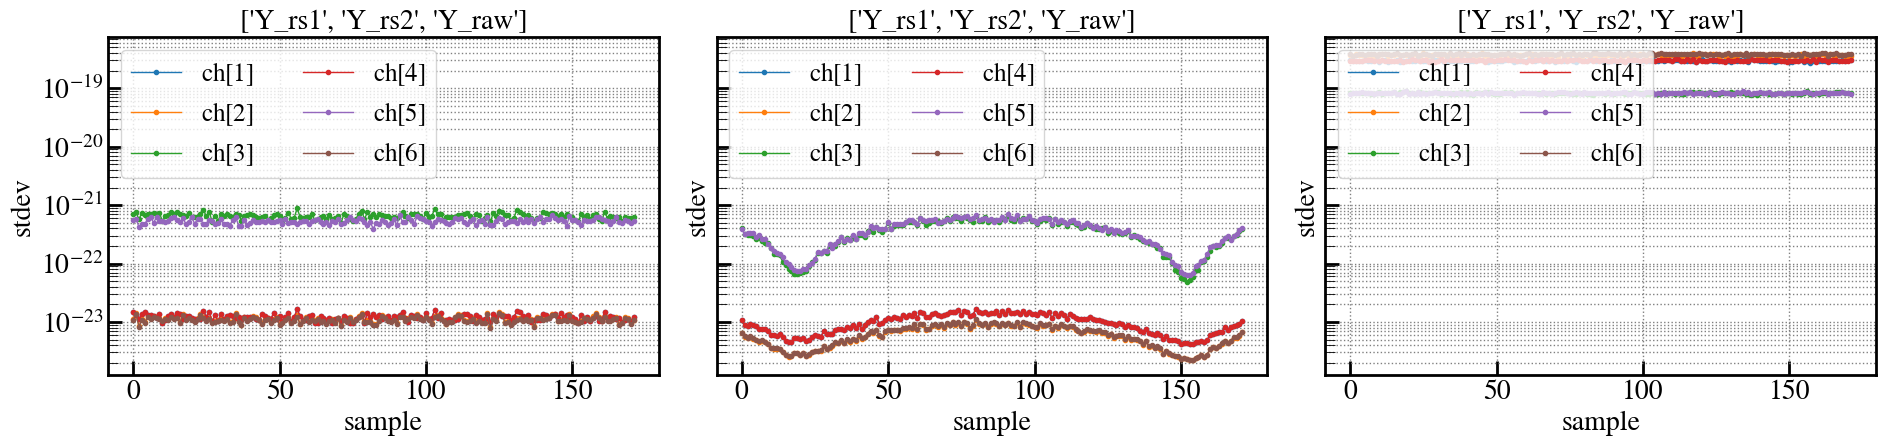

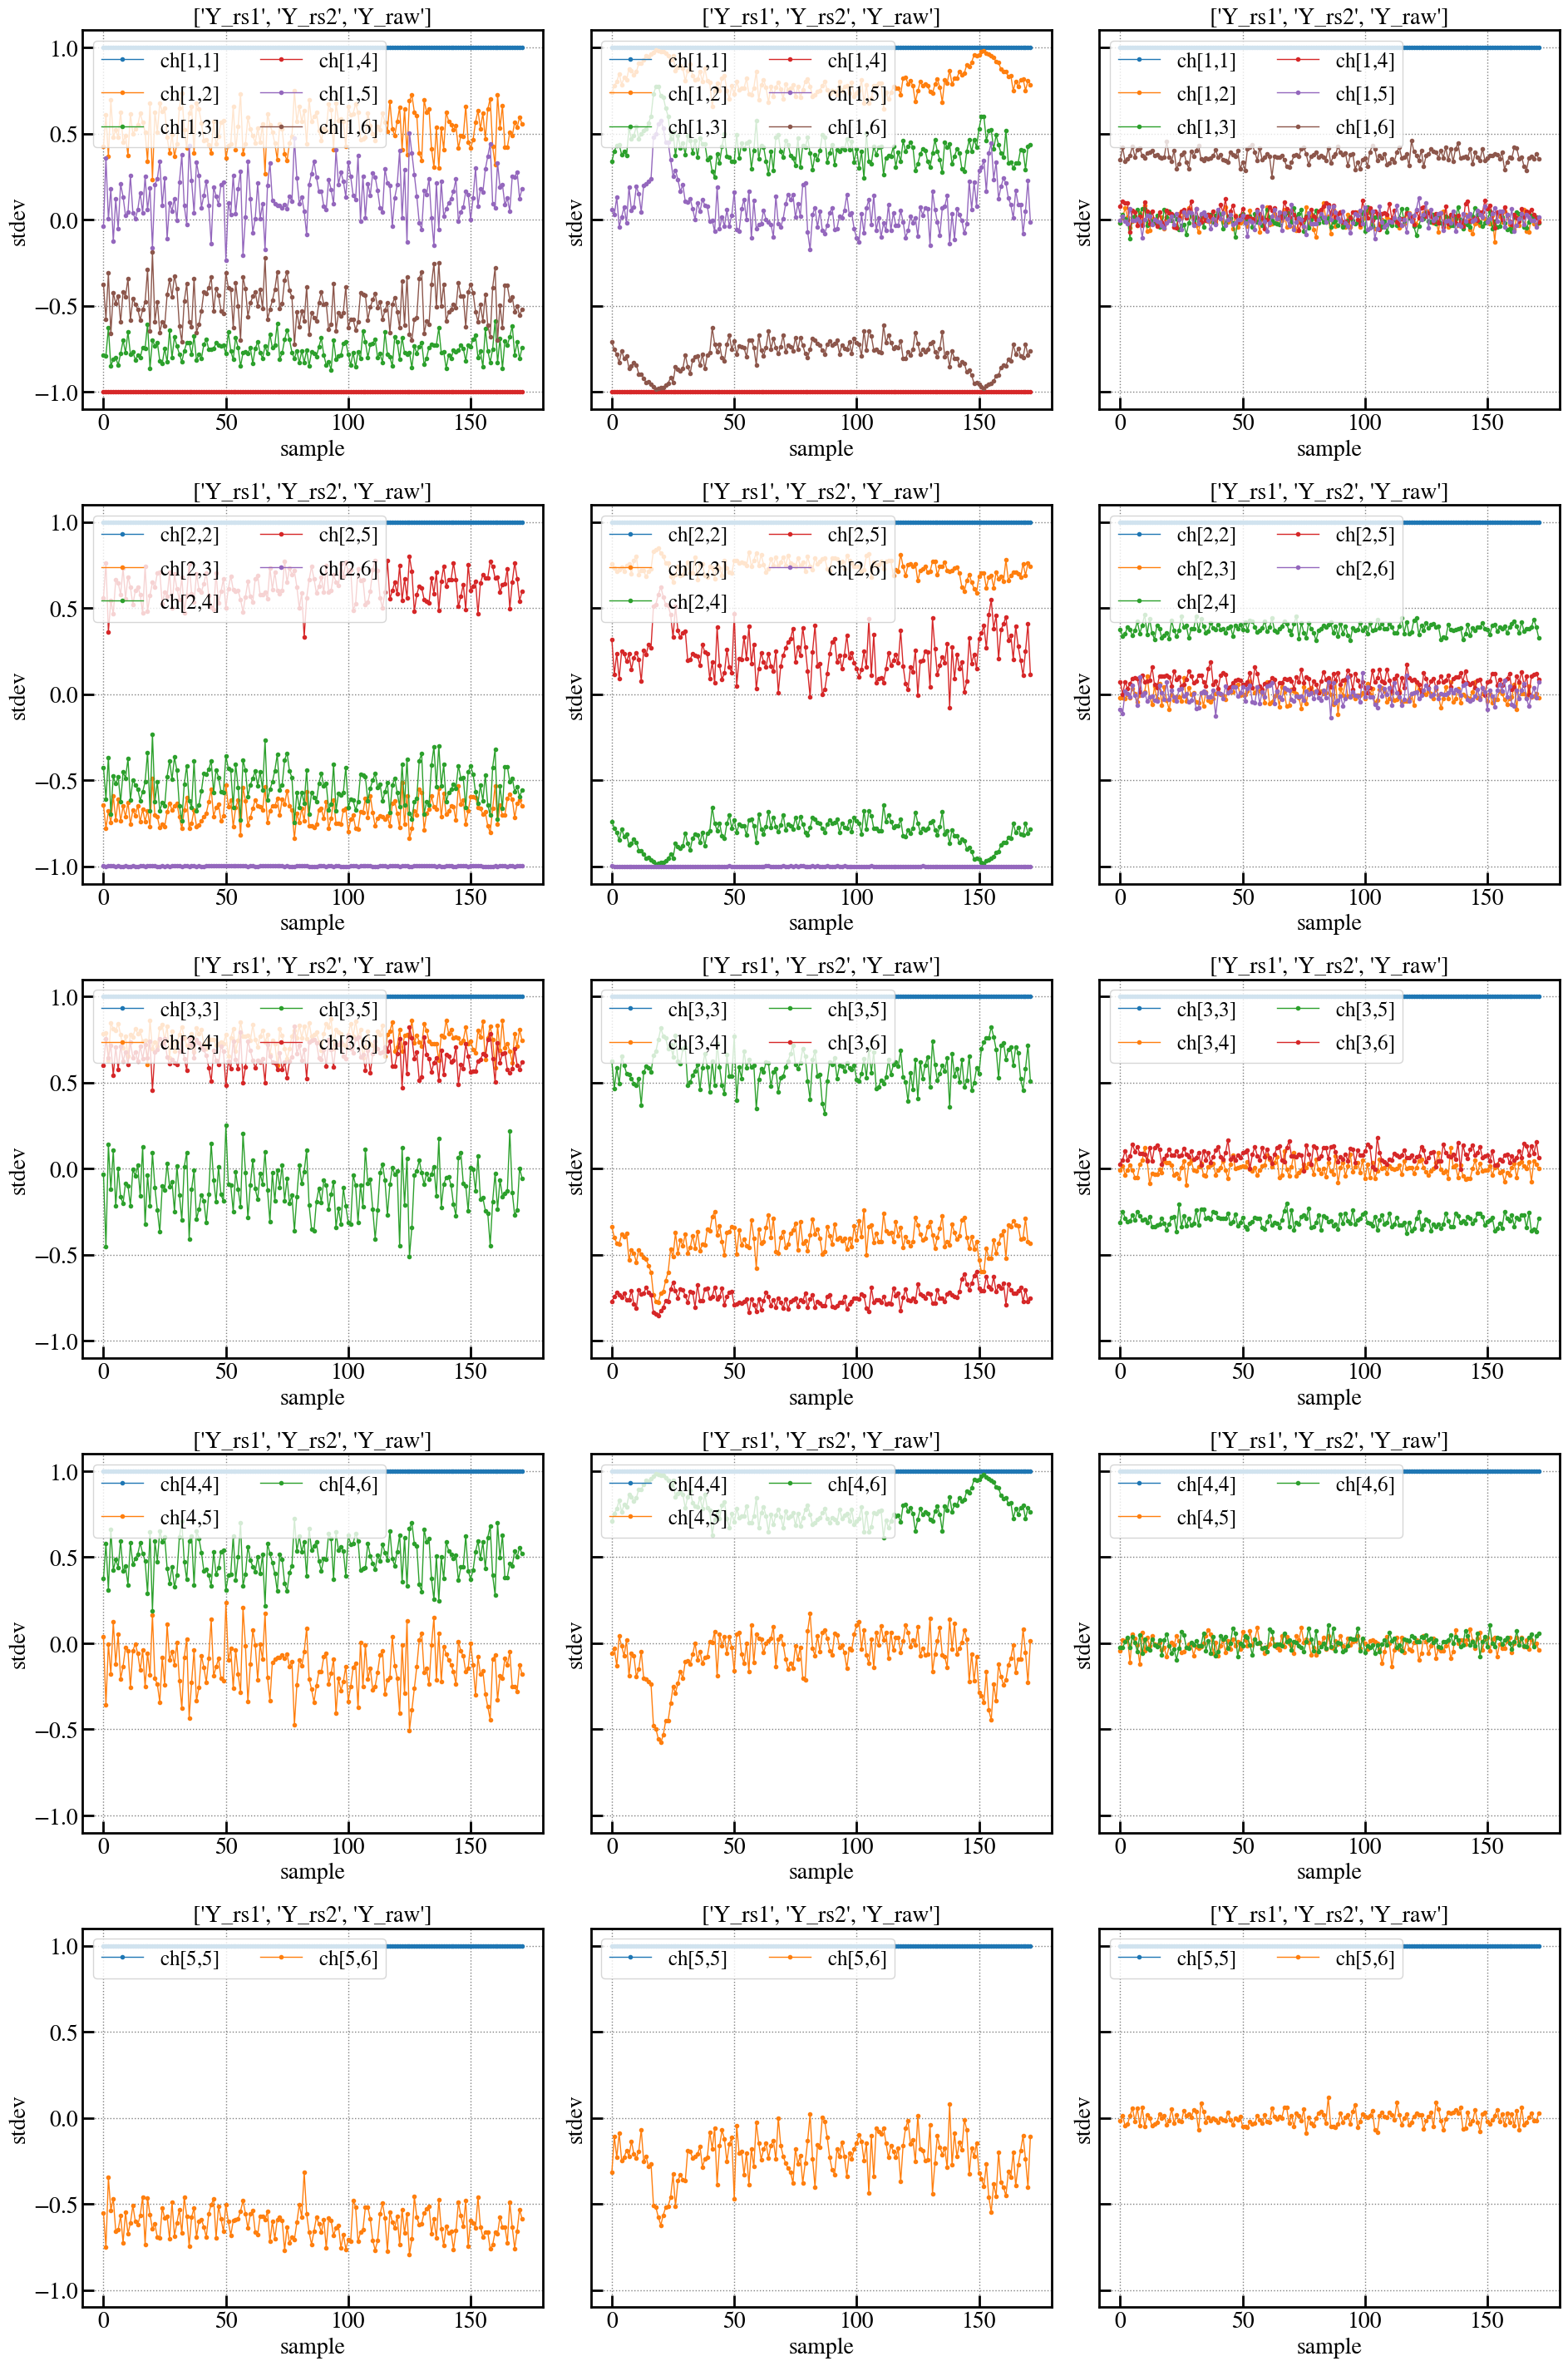

In [25]:
channel_analysis.temporal_variance_corr_plots(Ysets[:],
                                              nchan=6,
                                              title=titles)

In [26]:
freqs1, y_pci1_welch_mat = compute_welch_matrix(Ysets[0].T, **kwargs)
freqs2, y_pci2_welch_mat = compute_welch_matrix(Ysets[1].T, **kwargs)

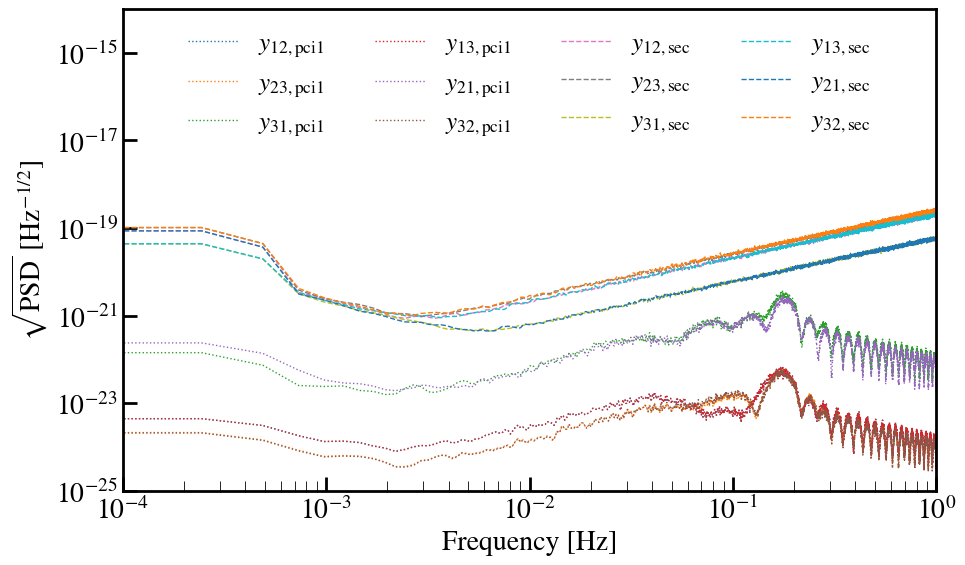

In [84]:
# Vizualize the single-link measurements in frequency domain
plotting.plotconfig(lbsize=20, lgsize=16, fsize=18, 
                    ticklabelsize=20, style='publication',
                    fontfamily = 'STIXGeneral')
fig, axes = plt.subplots(1, 1, figsize=(10, 6))

# For APCI
for i in range(6):
    axes.loglog(freqs, np.sqrt(y_pci1_welch_mat[:, i, i].real), 
                linewidth=1, ls=':',
                label=r'$y_{\mathrm{'+mosas_order[i]+',pci1}}$',
               rasterized=True)
#for i in range(6):
#    axes.loglog(freqs, np.sqrt(y_pci2_welch_mat[:, i, i].real), 
#                linewidth=1, 
#                label=r'$y_{\mathrm{'+mosas_order[i]+',pci2}}$',
#               rasterized=True)
for i in range(6):
    axes.loglog(freqs, np.sqrt(y_sec_welch_mat[:, i, i].real), 
                linewidth=1, ls='--',
                label=r'$y_{\mathrm{'+mosas_order[i]+',sec}}$',
                rasterized=True)
axes.legend(loc='upper center', ncol=4, frameon=False)
# axes.grid(linewidth=1, which='both', 
#           color='gray', 
#           linestyle='dotted')
axes.set_xlabel("Frequency [Hz]")
axes.set_ylabel(r"$\mathrm{\sqrt{PSD}}$ [$\mathrm{Hz}^{-1/2}$]")
axes.set_xlim([1e-4, 1])
axes.set_ylim([1e-25, 1e-14])
# axes.set_title("Single-link periodograms")
fig.savefig("single-link-periodogram.pdf", format="pdf", dpi=300)
plt.show()

Alertnative Y reconstruction

In [28]:
    def filter_single_link_data(self, ydata,n_channels=None):
        '''
        Compute recovered single-link channel vectors from a set of single-link data. This should yield 
        identical results to appropriately called compute_single_link_from_channels but we first implement
        separately for testing, since the stencil_compts stuff is new. This one is more low-level and 
        doesn't assum the stencil is selected.
        
        Parameters
        ----------
        ydata : ndarray 
            The raw single-link data-set to be transformed.

        Returns
        -------
        reconstructed_ydata : ndarray
            Reconstructed single link data channels
        '''
        if n_channels is None: n_channels=self.maxcompts
        y_transformer=self.components[-n_channels:,:6].T

        chans_data = self.apply_for_channels(ydata, n_channels)
        Z=np.dot(y_transformer,chans_data)
        print('single link data shape', Z.shape)
        return Z

In [29]:
Zsets=[np.array(xf.filter_single_link_data(y_full[:ns+2*nhalf, :].T, n_channels=nchannels)) for xf in filters]
print("Comparing single link")
diff=[Zsets[i]-Ysets[i] for i in range(order)]
print(diff)

single link data shape (6, 172800)
single link data shape (6, 172800)
Comparing single link
[array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], shape=(6, 172800)), array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], shape=(6, 172800))]


## 5. Estimate sensitivity
### Computation of empirical response with welch periodograms
Based and empirical sensitivity calculation simulated signal over simulated noise as developed in initial-dev-from-pylisa

In [30]:
# Some options and prep for the welch_matrix calc
nperseg = 1e4
welch_kwargs = {"fs": fs,
          "window": 'blackman',
          "nperseg": nperseg,
          "detrend": 'constant',
          "return_onesided": True,
          "scaling": 'density'}

#and for the orthogonalization...
#multiple_dot = lambda a,b: np.einsum("ijk, ikl -> ijl", a, b)
def multiple_dot(a_mat, b_mat):
    """
    Perform the matrix multiplication of two list of matrices.

    Parameters
    ----------
    a : ndarray
        series of m x n matrices (array of size p x m x n)
    b : ndarray
        series of n x k matrices (array of size p x n x k)

    Returns
    -------
    c : ndarray
        array of size p x m x k containg the dot products of all matrices
        contained in a and b.


    """

    return np.einsum("ijk, ikl -> ijl", a_mat, b_mat)


In [31]:

def estimate_sensitivity(pci, data_n, data_gw, n_channels=6, joint=True, single_link=False, welch_kwargs=welch_kwargs):
    
    # PCI transformation vector, size n_channel x p
    #v_pci = pci.v_pci(n_channels)
    # Projection of the data segment t
    #print('compute noise channels')
    #print('for',n_channels,'channels')
    #print('components shape',pci.components.shape)
    if single_link:
        e_pci_n = pci.filter_single_link_data(data_n,n_channels).T
        e_pci_gw = pci.filter_single_link_data(data_gw,n_channels).T
    else:
        e_pci_n = pci.apply_for_channels(data_n,n_channels).T
        e_pci_gw = pci.apply_for_channels(data_gw,n_channels).T
    #print(e_pci_n.shape,e_pci_n.shape)
    #print('compute welch')
    # Welch spectrum matrix for PCI variables from noise
    freqs, e_pci_n_mat = compute_welch_matrix(e_pci_n, **welch_kwargs)
    print(freqs, e_pci_n_mat)
    # Welch spectrum matrix for PCI variables from noise
    freqs, e_pci_gw_mat = compute_welch_matrix(e_pci_gw, **welch_kwargs)
    print(freqs, e_pci_gw_mat)
    # Orthogonalization
    _, s, vh = np.linalg.svd(e_pci_n_mat)
    # Apply the orthogonal transformation to the GW signal    
    e_pci_gw_mat_ortho = multiple_dot(vh, multiple_dot(e_pci_gw_mat, np.swapaxes(vh, 1, 2).conj()))
    # Apply the orthogonal transformation to the noise covariance
    e_pci_n_mat_ortho = multiple_dot(vh, multiple_dot(e_pci_n_mat, np.swapaxes(vh, 1, 2).conj()))
    # Output sensitivity for each variable, size nfreqs x n_channels
    # pci_sens = np.array([np.abs(s[:, j] / e_pci_gw_mat_ortho[:, j, j]) for j in range(n_channels)]).T
    pci_sens = np.array([np.abs(e_pci_n_mat_ortho[:, j, j] / e_pci_gw_mat_ortho[:, j, j]) for j in range(n_channels)]).T
    
    print("Computation completed.")
    if joint:
        pci_sens = 1 / np.sum(1/np.array(pci_sens), axis=1)
    
    return freqs, pci_sens

def process_data(y_noise, y_gw, fs, nhalf, order=1, n_channels=6, pca_y_noise=None, joint=False, pci_kwargs={}, welch_kwargs={}):
    '''
    Apply PCI and compute sensitivity all wrapped up together. If pda_y_noise is provided it is used
    only for computing the PCI and y_noise is used only for the sensitivity application
    '''
    
    if pca_y_noise is None: pca_y_noise=y_noise
        
    print('nhalf:',nhalf, 'sens data_size:',len(y_noise),'pca data_size:',len(pca_y_noise))
    
    # Get the length of the time series
    data_size = y_noise.shape[0]
    # data_noise = Data.from_instrument(instr_data)

    print('compute PCI')
    pci=pci_filter.PCIFilter(y_noise, fs, maxcompts=10, nhalf=nhalf,order=order,**pci_kwargs)
    
    result=estimate_sensitivity(pci, y_noise, y_gw, n_channels=n_channels, joint=joint, welch_kwargs=welch_kwargs)
    del(pci)
    
    return result

#### We need to read matching GW simulations results for the empirical sensitivity calculation

In [32]:
gw_path = workdir+dtpath["point_source"]+datasets["point_source"]+measpath

data_gw = Data.from_gws(gw_path,orbits)

#gw_dataset='tps/y'
#hdf5 = h5py.File(gw_path, 'r')
#dset=hdf5[gw_dataset]

#measurements = {f'isi_{link}': dset[:,ilink] for ilink, link in enumerate(mosas_order)}
#hdf5.close()

y_list = [data_gw.measurements[f'isi_{link}'] for link in mosas_order]
y_gw = np.array(y_list, dtype=np.float64).T[skip:, :]


You are using a GW file in a version that might not be fully supported


#### For comparison, we also need the TDI data

In [33]:
#tdipath1 = workdir + dtpath + 'noise_tdi1_4Hz.h5'
tdipath2 = workdir +  dtpath['noise'] + datasets['noise'] + '_noise_tdi2_4Hz.h5'
# open hdf5 TDI file
#tdi1 = h5py.File(tdipath1, 'r')
tdi2 = h5py.File(tdipath2, 'r')

x2_noise = tdi2['x'][()] / central_freq
y2_noise = tdi2['y'][()] / central_freq
z2_noise = tdi2['z'][()] / central_freq

tdi2_gw_file = workdir+dtpath["point_source"]+datasets["point_source"]+"_tdi2_4Hz.h5"

hdf5 = h5py.File(tdi2_gw_file, 'r')
x2_gw = hdf5['x'][()]
y2_gw = hdf5['y'][()]
z2_gw = hdf5['z'][()]
hdf5.close()

# Compute welch matrix for the TDI 2.0 noise
e_tdi2_n = np.array([x2_noise[skip:skip+ns],
                     y2_noise[skip:skip+ns],
                     z2_noise[skip:skip+ns]] ).T
freqs, p_tdi2_n_mat = compute_welch_matrix(e_tdi2_n, **welch_kwargs)
# Compute the welch matrix for the TDI 2.0 GW signal
e_tdi2_gw = np.array([x2_gw[skip:skip+ns],
                      y2_gw[skip:skip+ns],
                      z2_gw[skip:skip+ns]]).T
freqs, p_tdi2_gw_mat = compute_welch_matrix(e_tdi2_gw, **welch_kwargs)

# Orthogonalization
u_tdi, s_tdi, vh_tdi = np.linalg.svd(p_tdi2_n_mat)

# Apply the orthogonal transformation to the GW signal
p_tdi2_gw_mat_ortho = multiple_dot(vh_tdi, 

multiple_dot(p_tdi2_gw_mat, np.swapaxes(vh_tdi, 1, 2).conj()))

# Empirical orthogonalization of TDI
mean_tdi2 = 1 / np.sum(
    np.array([np.abs(p_tdi2_gw_mat_ortho[:, j_tdi, j_tdi] / np.abs(s_tdi[:, j_tdi])) for j_tdi in range(3)]), axis=0)

#### PCI channel sensitivities

In [34]:
print(ns)
print(y_full[0:ns,:].T)
print(y_gw[0:ns,:].T)
display(welch_kwargs)

172800
[[ 2.36789371e-13  3.45532554e-14 -5.79191277e-14 ...  3.81376029e-14
  -4.48951605e-14  5.25240079e-13]
 [ 8.19541394e-14  2.41011355e-13 -2.09498312e-13 ... -1.03982210e-13
  -1.86931446e-13  3.13177163e-13]
 [-3.65051343e-20 -8.23931284e-20  1.15157988e-19 ... -2.41456237e-20
  -5.47562444e-20 -2.29198696e-19]
 [ 2.36839318e-13  3.44093090e-14 -5.79031063e-14 ...  3.81753492e-14
  -4.43270805e-14  5.25434708e-13]
 [-2.01089786e-19  5.43377141e-20 -4.31491065e-20 ... -2.92254481e-19
  -2.85415334e-19 -2.86305129e-19]
 [ 8.08044387e-14  2.42138178e-13 -2.09185771e-13 ... -1.03283123e-13
  -1.88522472e-13  3.13398884e-13]]
[[ 0.61568665  3.11150118  0.22862689 ... -0.65858273  0.49262047
  -1.56951593]
 [ 0.79785803  0.84683444  0.89825605 ... -1.26818121  0.31876584
  -0.29827401]
 [ 0.29231389  0.31167007  0.17948646 ... -0.02209964  0.09356474
   0.33553696]
 [-0.61735169 -2.91624795 -0.2734935  ... -0.21574312  0.12478146
   1.49127856]
 [-0.20579966 -0.21827452 -0.10400534 

{'fs': np.float64(4.0),
 'window': 'blackman',
 'nperseg': 10000.0,
 'detrend': 'constant',
 'return_onesided': True,
 'scaling': 'density'}

In [35]:
#Test as it appears in the initial-dev notebook
nh=45
pci_sens_list = [
#    ["PCI-0 std", process_data(y_full[:ns, :].T, y_gw[0:ns, :].T, kwargs['fs'], nh, order=0, n_channels=6, joint=True, pci_kwargs={'sort_by_rms':False},welch_kwargs=kwargs)],
#    ["PCI-1 std", process_data(y_full[:ns, :].T, y_gw[0:ns, :].T, kwargs['fs'], nh, order=1, n_channels=6, joint=True, pci_kwargs={'sort_by_rms':False},welch_kwargs=kwargs)],
#    ["PCI-2 std", process_data(y_full[:ns, :].T, y_gw[0:ns, :].T, kwargs['fs'], nh, order=2, n_channels=6, joint=True, pci_kwargs={'sort_by_rms':False},welch_kwargs=kwargs)],
#    ["PCI-0 rms", process_data(y_full[:ns, :].T, y_gw[0:ns, :].T, kwargs['fs'], nh, order=0, n_channels=6, joint=True, pci_kwargs={'sort_by_rms':True},welch_kwargs=kwargs)],
#    ["PCI-1 rms", process_data(y_full[:ns, :].T, y_gw[0:ns, :].T, kwargs['fs'], nh, order=1, n_channels=6, joint=True, pci_kwargs={'sort_by_rms':True},welch_kwargs=kwargs)],
    ["PCI-2 rms", process_data(y_full[:ns, :].T, y_gw[0:ns, :].T, fs, nh, order=2, n_channels=6, joint=True, pci_kwargs={'sort_by_rms':True},welch_kwargs=welch_kwargs)] 
]

nhalf: 45 sens data_size: 6 pca data_size: 6
compute PCI
(172710, 1638)
variance check rms: 1.3543977773240618e-08
shapes of chans, cov, components: (10, 172710) (10, 10) (10, 1638)
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
channel covariance diagonality test on 10 components: 5.72996262938449e-11
component diagonality test on 10 components: 1.4092962045715033e-15
[0.0000e+00 4.0000e-04 8.0000e-04 ... 1.9992e+00 1.9996e+00 2.0000e+00] [[[ 1.90334092e-44+0.00000000e+00j  5.48753192e-45+0.00000000e+00j
   -6.84596883e-47+0.00000000e+00j  2.33029928e-44+0.00000000e+00j
    3.42796605e-45+0.00000000e+00j -1.39211529e-45+0.00000000e+00j]
  [ 5.48753192e-45-0.00000000e+00j  3.67181235e-45+0.00000000e+00j
   -2.58364625e-46+0.00000000e+00j  7.39435556e-45+0.00000000e+00j
    1.25587454e-45+0.00000000e+00j -9.62295507e-49+0.00000000e+00j]
  [-6.84596883e-47-0.00000000e+00j -2.58364625e-46-0.00000000e+00j
    2.39745903e-45+0.00000000e+00j  1.34796391e-46+0.00000000e+00j
    2.26004804e-46+0.00000000e+00

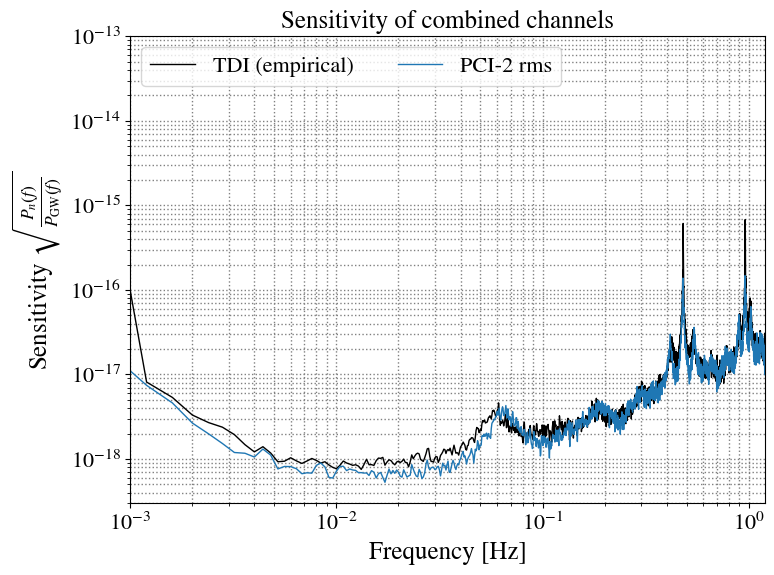

In [36]:
plotting.plotconfig(lbsize=18, lgsize=16)
_, axes = plt.subplots(1, 1, figsize=(8, 6))
axes.loglog(freqs, np.sqrt(mean_tdi2*ns/fs), 
            linewidth=1, label=r'TDI (empirical)',
            color='black')
for j in range(len(pci_sens_list)):
    #print(j)
    axes.loglog(pci_sens_list[j][1][0], np.sqrt(pci_sens_list[j][1][1]*ns/fs), 
                linewidth=1, label=pci_sens_list[j][0], rasterized=True)
axes.legend(loc='upper left', ncol=2)
axes.set_xlabel("Frequency [Hz]")
axes.set_ylabel(r"Sensitivity $\sqrt{\frac{P_{n}(f)}{P_{\mathrm{GW}}(f)}}$")
axes.set_xlim([1e-3, 1.2])
axes.set_ylim([3e-19, 1e-13])
axes.grid(linewidth=1, which='both', color='gray', linestyle='dotted')
axes.set_title("Sensitivity of combined channels")
plt.show()

In [37]:
pci_sens_list = []
#pci_sens_list += [
#    ["PCI-"+str(j)+" std", estimate_sensitivity(pca_list[j],y_full[:ns, :].T, y_gw[0:ns, :].T, n_channels=6, joint=True, welch_kwargs=welch_kwargs)] 
#     for j in range(3)]
pci_sens_list += [
    ["PCI-"+str(j)+" rms", estimate_sensitivity(pca_list_rs[j],y_full[:ns, :].T, y_gw[0:ns, :].T, n_channels=6, joint=True, welch_kwargs=welch_kwargs)] 
     for j in range(3)]




[0.0000e+00 4.0000e-04 8.0000e-04 ... 1.9992e+00 1.9996e+00 2.0000e+00] [[[ 1.31194492e-41+0.00000000e+00j -5.59855886e-42+0.00000000e+00j
    1.36907439e-42+0.00000000e+00j -1.19927380e-43+0.00000000e+00j
   -3.09467975e-43+0.00000000e+00j  8.50772537e-43+0.00000000e+00j]
  [-5.59855886e-42-0.00000000e+00j  2.59632151e-42+0.00000000e+00j
   -5.59856929e-43+0.00000000e+00j  1.07184260e-43+0.00000000e+00j
    1.57329283e-43+0.00000000e+00j -3.68570465e-43+0.00000000e+00j]
  [ 1.36907439e-42-0.00000000e+00j -5.59856929e-43-0.00000000e+00j
    2.03966225e-43+0.00000000e+00j -1.66162225e-44+0.00000000e+00j
   -6.73864336e-44+0.00000000e+00j  4.70631489e-44+0.00000000e+00j]
  [-1.19927380e-43-0.00000000e+00j  1.07184260e-43-0.00000000e+00j
   -1.66162225e-44-0.00000000e+00j  1.25237978e-43+0.00000000e+00j
   -2.59068091e-44+0.00000000e+00j  3.48787557e-44+0.00000000e+00j]
  [-3.09467975e-43-0.00000000e+00j  1.57329283e-43-0.00000000e+00j
   -6.73864336e-44-0.00000000e+00j -2.59068091e-44-0.

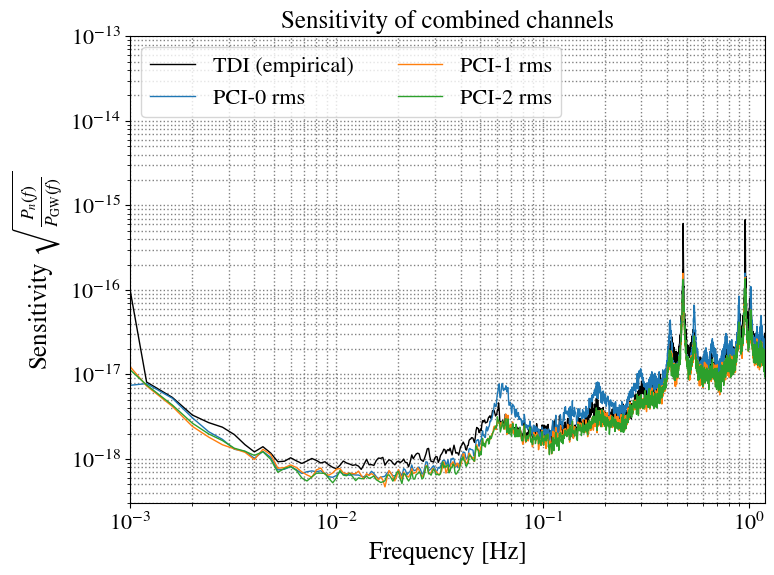

In [38]:
plotting.plotconfig(lbsize=18, lgsize=16)
_, axes = plt.subplots(1, 1, figsize=(8, 6))
axes.loglog(freqs, np.sqrt(mean_tdi2*ns/fs), 
            linewidth=1, label=r'TDI (empirical)',
            color='black')
for j in range(len(pci_sens_list)):
    #print(j)
    axes.loglog(pci_sens_list[j][1][0], np.sqrt(pci_sens_list[j][1][1]*ns/fs), 
                linewidth=1, label=pci_sens_list[j][0], rasterized=True)
axes.legend(loc='upper left', ncol=2)
axes.set_xlabel("Frequency [Hz]")
axes.set_ylabel(r"Sensitivity $\sqrt{\frac{P_{n}(f)}{P_{\mathrm{GW}}(f)}}$")
axes.set_xlim([1e-3, 1.2])
axes.set_ylim([3e-19, 1e-13])
axes.grid(linewidth=1, which='both', color='gray', linestyle='dotted')
axes.set_title("Sensitivity of combined channels")
plt.show()

Reconstructed single link sensitivities

In [39]:
pci_sens_list = []
#pci_sens_list += [
#    ["PCI-"+str(j)+" std", estimate_sensitivity(pca_list[j],y_full[:ns, :].T, y_gw[0:ns, :].T, n_channels=6, joint=True, welch_kwargs=welch_kwargs)] 
#     for j in range(3)]
pci_sens_list += [
    ["PCI-"+str(j)+" filtered", estimate_sensitivity(pca_list_rs[j],y_full[:ns, :].T, y_gw[0:ns, :].T, n_channels=6, joint=True, single_link=True, welch_kwargs=welch_kwargs)] 
     for j in range(3)]

single link data shape (6, 172710)
single link data shape (6, 172710)
[0.0000e+00 4.0000e-04 8.0000e-04 ... 1.9992e+00 1.9996e+00 2.0000e+00] [[[ 8.35628366e-48+0.00000000e+00j  6.52577579e-51+0.00000000e+00j
   -2.66127868e-47+0.00000000e+00j -8.35628357e-48+0.00000000e+00j
   -5.24476265e-47+0.00000000e+00j  1.39844928e-50+0.00000000e+00j]
  [ 6.52577579e-51-0.00000000e+00j  2.73789025e-53+0.00000000e+00j
   -5.71840321e-50+0.00000000e+00j -6.52577549e-51+0.00000000e+00j
   -4.85632829e-50+0.00000000e+00j  3.51128831e-53+0.00000000e+00j]
  [-2.66127868e-47-0.00000000e+00j -5.71840321e-50-0.00000000e+00j
    1.50869655e-46+0.00000000e+00j  2.66127861e-47+0.00000000e+00j
    1.82450283e-46+0.00000000e+00j -8.37382215e-50+0.00000000e+00j]
  [-8.35628357e-48-0.00000000e+00j -6.52577549e-51-0.00000000e+00j
    2.66127861e-47-0.00000000e+00j  8.35628347e-48+0.00000000e+00j
    5.24476266e-47+0.00000000e+00j -1.39844923e-50+0.00000000e+00j]
  [-5.24476265e-47-0.00000000e+00j -4.85632829e-50

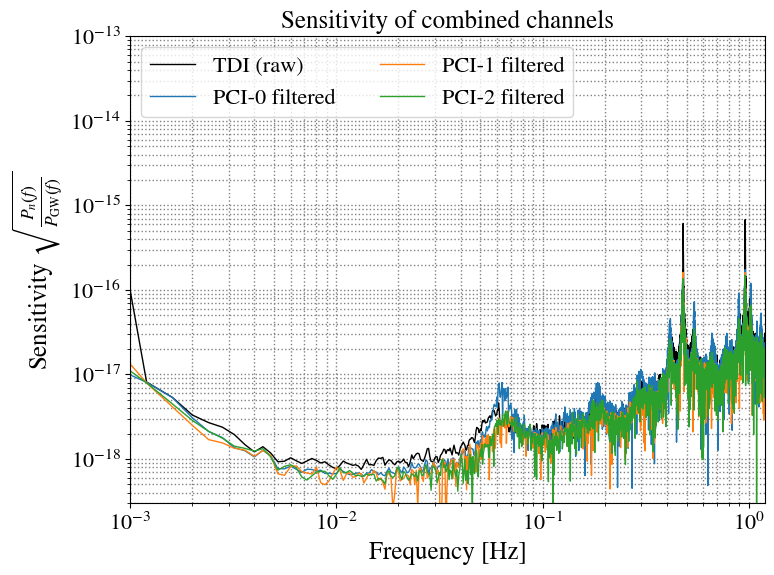

In [40]:
plotting.plotconfig(lbsize=18, lgsize=16)
_, axes = plt.subplots(1, 1, figsize=(8, 6))
axes.loglog(freqs, np.sqrt(mean_tdi2*ns/fs), 
            linewidth=1, label=r'TDI (raw)',
            color='black')
for j in range(len(pci_sens_list)):
    #print(j)
    axes.loglog(pci_sens_list[j][1][0], np.sqrt(pci_sens_list[j][1][1]*ns/fs), 
                linewidth=1, label=pci_sens_list[j][0], rasterized=True)
axes.legend(loc='upper left', ncol=2)
axes.set_xlabel("Frequency [Hz]")
axes.set_ylabel(r"Sensitivity $\sqrt{\frac{P_{n}(f)}{P_{\mathrm{GW}}(f)}}$")
axes.set_xlim([1e-3, 1.2])
axes.set_ylim([3e-19, 1e-13])
axes.grid(linewidth=1, which='both', color='gray', linestyle='dotted')
axes.set_title("Sensitivity of combined channels")
plt.show()

### PCI of single noise components

#### First we load the single noise data and generate the ys for those

In [41]:
# Get secondary noises
lockstr = 'locking_n1_12_baseline_noise_'

noises = ['test-mass', 'oms']

y_noise = {}

for nn in noises:
    noisepath = workdir + dtpath['noise']+ lockstr + nn + '_4Hz.h5'
    print(noisepath)
    
    data_noise = Data.from_instrument(noisepath)
    
    y_noise[nn] = build_data_vector(data_noise, skip=skip, dtype=np.float64)

You are using a measurement file in a version that might not be fully supported


/Users/ecastel2/Documents/research/GSFC/pci-inrep/simulations/2025-03-19_13h05_locking_n1_12_baseline_noise_test-mass_4Hz.h5


You are using a measurement file in a version that might not be fully supported


/Users/ecastel2/Documents/research/GSFC/pci-inrep/simulations/2025-03-19_13h05_locking_n1_12_baseline_noise_oms_4Hz.h5


In [42]:
y_noise

{'test-mass': array([[-9.29957222e-21,  2.28891932e-20,  4.29391186e-20,
         -5.21630608e-20, -1.06906330e-19,  1.54279387e-20],
        [-2.65217309e-20,  6.15654640e-21, -2.77402719e-20,
          1.11940148e-20, -2.00517362e-20,  3.83235440e-21],
        [-7.56437295e-20, -1.68547521e-20, -2.10950977e-20,
         -1.43672384e-20, -4.83657258e-20,  3.38981087e-21],
        ...,
        [-5.02903750e-19,  5.67800560e-19, -1.51470075e-19,
         -1.05769375e-19, -5.82202862e-19,  5.37605245e-19],
        [-5.73680645e-19,  5.83091841e-19, -9.29524266e-20,
         -1.24663875e-19, -4.74860240e-19,  6.02636377e-19],
        [-5.29888901e-19,  5.42075898e-19, -8.00005654e-20,
         -1.32908163e-19, -6.04130877e-19,  5.63544178e-19]],
       shape=(979200, 6)),
 'oms': array([[ 3.91972080e-19, -6.95045476e-19, -7.94442531e-20,
         -6.87015798e-19, -9.41834557e-20,  4.42480889e-19],
        [-2.68413869e-19,  7.45682411e-19, -5.46528568e-20,
          4.41630159e-19,  7.438

single link data shape (6, 172710)
single link data shape (6, 172710)
[0.0000e+00 4.0000e-04 8.0000e-04 ... 1.9992e+00 1.9996e+00 2.0000e+00] [[[ 7.78978589e-49+0.00000000e+00j  3.03111261e-49+0.00000000e+00j
   -2.65749187e-48+0.00000000e+00j -7.78978756e-49+0.00000000e+00j
   -1.53495877e-47+0.00000000e+00j -3.19839017e-49+0.00000000e+00j]
  [ 3.03111261e-49-0.00000000e+00j  1.33499522e-49+0.00000000e+00j
   -1.85676400e-48+0.00000000e+00j -3.03111321e-49+0.00000000e+00j
   -7.93303886e-48+0.00000000e+00j -1.42965123e-49+0.00000000e+00j]
  [-2.65749187e-48-0.00000000e+00j -1.85676400e-48-0.00000000e+00j
    4.43549754e-46+0.00000000e+00j  2.65748897e-48+0.00000000e+00j
    4.32678143e-46+0.00000000e+00j  2.08848505e-48+0.00000000e+00j]
  [-7.78978756e-49-0.00000000e+00j -3.03111321e-49-0.00000000e+00j
    2.65748897e-48-0.00000000e+00j  7.78978923e-49+0.00000000e+00j
    1.53495882e-47+0.00000000e+00j  3.19839079e-49+0.00000000e+00j]
  [-1.53495877e-47-0.00000000e+00j -7.93303886e-48

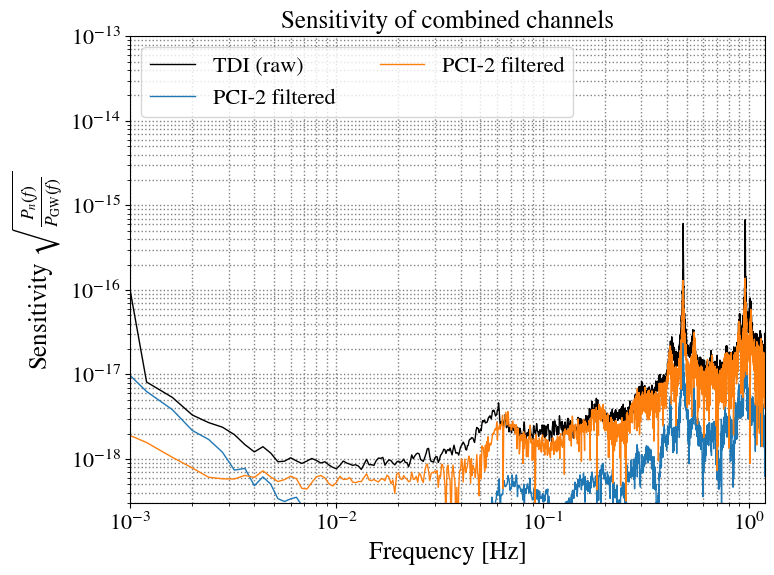

In [45]:
pci_sens_list = []
#pci_sens_list += [
#    ["PCI-"+str(j)+" std", estimate_sensitivity(pca_list[j],y_full[:ns, :].T, y_gw[0:ns, :].T, n_channels=6, joint=True, welch_kwargs=welch_kwargs)] 
#     for j in range(3)]
pci_sens_list += [
    ["PCI-"+str(j)+" filtered", estimate_sensitivity(pca_list_rs[j],y_noise[nn][:ns, :].T, y_gw[0:ns, :].T, n_channels=6, joint=True, single_link=True, welch_kwargs=welch_kwargs)] 
     for j in range(2,3) for nn in noises]

plotting.plotconfig(lbsize=18, lgsize=16)
_, axes = plt.subplots(1, 1, figsize=(8, 6))
axes.loglog(freqs, np.sqrt(mean_tdi2*ns/fs), 
            linewidth=1, label=r'TDI (raw)',
            color='black')
for j in range(len(pci_sens_list)):
    #print(j)
    axes.loglog(pci_sens_list[j][1][0], np.sqrt(pci_sens_list[j][1][1]*ns/fs), 
                linewidth=1, label=pci_sens_list[j][0], rasterized=True)
axes.legend(loc='upper left', ncol=2)
axes.set_xlabel("Frequency [Hz]")
axes.set_ylabel(r"Sensitivity $\sqrt{\frac{P_{n}(f)}{P_{\mathrm{GW}}(f)}}$")
axes.set_xlim([1e-3, 1.2])
axes.set_ylim([3e-19, 1e-13])
axes.grid(linewidth=1, which='both', color='gray', linestyle='dotted')
axes.set_title("Sensitivity of combined channels")
plt.show()